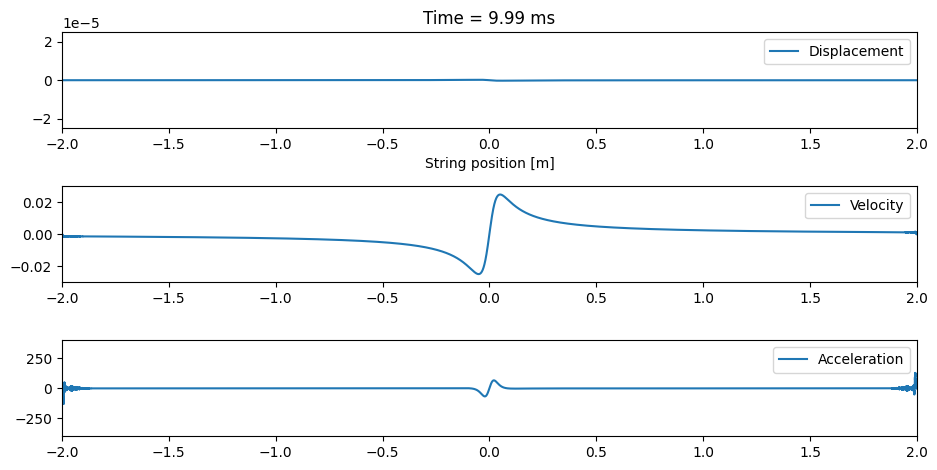

In [4]:
import numpy as np
from scipy.integrate import solve_ivp
from scipy import sparse
import matplotlib.pyplot as plt
from matplotlib import animation, rc
from IPython.display import HTML

rc('animation', html='jshtml', embed_limit=2**32)


# Initial params
dz = 0.0001
x0 = -2
xf = 2
z_string = np.arange(x0, xf, dz) # string
arr_dim = z_string.size
v_wave = 400 # Wavespeed [m/s] = sqrt(T / mu)
b = .05 # impact parameter, 1 cm away
G = 1
M = 1
v_0 = (z_string * G * M) / ((b**2 + z_string**2) * v_wave) # initial velocity as function of z
y_0 = np.zeros(arr_dim) # initial position as function of z

# Laplace operator with finite differences
laplacian = sparse.diags([1, -2, 1], [-1, 0, 1], shape= (arr_dim, arr_dim)) / dz**2

def couple_fun(t, u):
    """" 
    Function that returns first derivative in time => u is coupled position and velocity =>
        First N points return velocity: second N points of u
        Second N points return accelleration: v_p^2 * Laplacian.[first N points of u]
    """
    u[0] = 0 # fixed ends
    u[arr_dim - 1] = 0 #fixed ends
    du = np.zeros(2 * arr_dim) 
    # velocity is second half of coupled array (u)
    du[:arr_dim] = u[arr_dim:] 
    du[0] = 0 # fixed ends
    du[arr_dim - 1] = 0 # fixed ends
    # acceleration is wave eq on first half of coupled array (u)
    du[arr_dim:] = v_wave**2 * laplacian.dot(u[:arr_dim]) 
    du[arr_dim] = 0 # fixed ends
    du[-1] = 0 # fixed end
    return du

# Initialize coupled array
u_0 = np.zeros(2*arr_dim)
u_0[:arr_dim] = y_0
u_0[arr_dim:] = v_0

# time array
dt = 0.00001
t0 = 0.0
tf = 0.01
t_eval = np.arange(t0, tf, dt)

sol = solve_ivp(couple_fun, t_span= [t0, tf], y0= u_0, t_eval= t_eval, method="RK23")

fig1, (ax1, ax2, ax3) = plt.subplots(3,1)
ax1.set_xlabel('String position [m]')
title = ax1.set_title(' ')
line1, = ax1.plot([], [], label='Displacement')
line2, = ax2.plot([], [], label='Velocity')
line3, = ax3.plot([], [], label='Acceleration')
ax1.set_ylim(-b/(5 * v_wave), b/(5 * v_wave))
ax1.set_xlim(x0, xf)
ax2.set_ylim(-1.2*(v_0.max()), 1.2*v_0.max())
ax2.set_xlim(x0,xf)
ax3.set_ylim(-1/b**2, 1/b**2)
ax3.set_xlim(x0, xf)
ax1.legend()
ax2.legend()
ax3.legend()

def accell_mix(t):
    # Finite differences, favor symmetric difference
    d = 2
    if t == 0:
        less_dt = sol.y[arr_dim:, t]
        d = 1
    else:
        less_dt = sol.y[arr_dim:, t - 1]
    if t == len(sol.t) - 1:
        more_dt = sol.y[arr_dim:, t]
        d = 1
    else:
        more_dt = sol.y[arr_dim:, t + 1]  
    return (more_dt - less_dt) / (d * dt)

def init():
    line1.set_data([],[])
    line2.set_data([],[])
    line3.set_data([],[])
    return line1, line2, 

def animate(i):
    line1.set_data(z_string, sol.y[:arr_dim, i])
    line2.set_data(z_string, sol.y[arr_dim:, i])
    line3.set_data(z_string, accell_mix(i))
    title.set_text('Time = {:.2f} ms'.format(1000*sol.t[i]))
    return line1, line2,

anim = animation.FuncAnimation(fig1, animate, init_func=init, frames=len(sol.t), interval=5, blit=True)
fig1.tight_layout()
fig1.set_figwidth(10)
writervideo = animation.FFMpegWriter(fps=60)
anim.save('SimpleLong.mp4', writervideo)
# HTML(anim.to_jshtml())





